In [1]:
# default_exp simulations

# module name here

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F

In [4]:
torch.cuda.is_available()

True

# Parameters

In [5]:
class TrueParameters:
    def __init__(self):
        # Hyperparameters
        self.S,self.N = 2,10

        # z
        self.B = 3
        self.P = torch.rand((self.B,self.B)) + torch.eye(self.B,self.B)
        self.Wx = torch.rand(self.B)

        # h
        self.H_dim = 2
        self.mu_h = torch.randn(self.B, self.H_dim)
        self.sigma_h = torch.rand(self.B, self.H_dim).view(self.B, self.H_dim) * torch.randint(1,10, (1,), dtype=torch.float32)

        # i
        self.beta_a = torch.tensor([-np.log(4), 0.,0.])
        self.beta_b = torch.tensor([0., 0.,0.])

        # y
        self.Y_dim = 3
        self.W_mu_y = torch.randn(self.H_dim, self.Y_dim)
        self.W_sigma_y = torch.rand(self.H_dim, self.Y_dim)


tensor([[6.2833, 2.0133],
        [3.8066, 6.5045],
        [8.2523, 4.9759]])


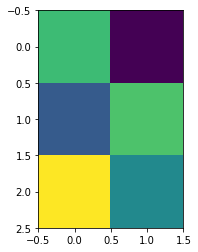

In [6]:
Params = TrueParameters()
print(Params.sigma_h)
plt.imshow(Params.sigma_h)

# Helper functions

In [7]:
transform_x = lambda t: torch.sin(t/200)*.7 - .1

In [8]:
def link_gamma(xn, zn, Params):
    data = torch.tensor([1., xn, zn])
    a,b = (torch.dot(Params.beta_a, data).mul(-1).exp(), torch.dot(Params.beta_b, data).mul(-1).exp())
    # print(a,b)
    return a,b

In [9]:
def sample_using_logits(logits):
    return dist.Categorical(logits=logits).sample()

In [10]:
#export
def get_time_from_intervals(I):
    last_dim_size = I.shape[-1]
    I = F.pad(I, (1,0)) #pads the last dimension with width=1 on the left and width=0 on the right. Value of padding=0
    I = I.cumsum(dim=-1)
    # Note: new I has one element extra than initial I on the final dimension. This cuts that one last element in a general way
    I = torch.stack([torch.select(I, I.dim()-1, i) for i in range(last_dim_size)], dim=-1)
    return I

# Simulation

## X, Z, I

In [11]:
def simulate_XZI_seq(Params):
    t = torch.tensor([0.])
    X_s = [transform_x(t)]
    Z_s = [sample_using_logits(Params.Wx*X_s[0])]
    I_s = [dist.Gamma(*link_gamma(X_s[0], Z_s[0], Params)).sample()]

    for n in range(1, Params.N):
        t += I_s[-1]
        X_s.append(transform_x(t) + torch.randn((1,))*.1) #uses current t which is a function of all I_{t'}, t' < t
        Z_s.append(sample_using_logits(Params.Wx*X_s[-1] + Params.P[Z_s[-1]])) #X_{t} and Z_{t-1}
        I_s.append(dist.Gamma(*link_gamma(X_s[-1], Z_s[-1], Params)).sample()) #X_{t} and Z_{t}
  
    X_s, Z_s, I_s = torch.tensor(X_s), torch.tensor(Z_s), torch.tensor(I_s)
    return X_s, Z_s, I_s

def simulate_XZI(Params):
    X, Z, I = [], [], []
    for s in range(Params.S):
        X_s, Z_s, I_s = simulate_XZI_seq(Params)
        X.append(X_s)
        Z.append(Z_s)
        I.append(I_s)

    return torch.stack(X, dim=0), torch.stack(Z, dim=0), torch.stack(I, dim=0)



## H

In [12]:
def simulate_H(Z,Params):
    H = []
    for s in range(Params.S):
        Z_s = Z[s]
        H_s = torch.stack([dist.Normal(Params.mu_h[Z_s[n]], Params.sigma_h[Z_s[n]]).sample() for n in range(Params.N)], dim=0)
        H.append(H_s)
    return torch.stack(H, dim=0) #shape: (S,T,H_dim)

## Y

In [13]:
def simulate_Y(H, Params):
    mu, sigma = torch.matmul(H, Params.W_mu_y), torch.matmul(H, Params.W_sigma_y)
    Y = dist.Normal(mu, sigma).sample()
    return Y

# Generate FULL DATASET

In [ ]:
#export
def simulate_data(Params):
    X, Z, I = simulate_XZI(Params)
    T = get_time_from_intervals(I)
    H = simulate_H(Z, Params)
    Y = simulate_Y(H, Params)
    return I,Y,T,X,Z,H

# TEST

In [14]:
def test():
    Params = TrueParameters()
    X, Z, I = simulate_XZI(Params)
    T = get_time_from_intervals(I)
    H = simulate_H(Z, Params)
    Y = simulate_Y(H, Params)
    return X,Z,I,T,H,Y

In [15]:
X,Z,I,T,H,Y = test()

In [16]:
X.shape,Z.shape,I.shape,T.shape,H.shape,Y.shape

(torch.Size([2, 10]),
 torch.Size([2, 10]),
 torch.Size([2, 10]),
 torch.Size([2, 10]),
 torch.Size([2, 10, 2]),
 torch.Size([2, 10, 3]))

In [17]:
## Some Visualizations

In [18]:
def visualize(Params, X,T,I):
    fig, ax = plt.subplots(2,2, figsize=(8,8))


    ax[0,0].plot(torch.linspace(1e-6,T[0,-1],100), transform_x(torch.linspace(1e-6,T[0,-1],100)))
    ax[0,0].scatter(T[0], X[0])
    ax[0,0].set_title("Latent state $x(t)$ (1 Seq)")

    im = ax[0,1].imshow(Params.P)
    fig.colorbar(im, ax=ax[0,1])
    ax[0,1].set_title("Base transition logits")

    for s in range(min(5, Params.S)):
        ax[1,0].scatter(T[s], torch.zeros_like(T[s])+s)
    ax[1,0].set_title("Event Times (5 indpt sequences)")

    ax[1,1].hist(I[0].numpy(), bins=20)
    ax[1,1].set_title("Histogram of Interval Times (1 sequence)")

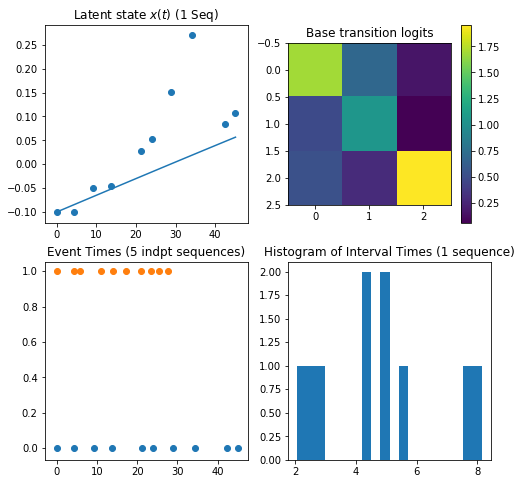

In [19]:
visualize(Params,X,T,I)

In [20]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_simulations.ipynb.
Converted index.ipynb.
